# Using an Image Classification Neural Network to Identify Various Sports (Part 2)
I used the fastai library to work with the data as well as tune the neural networks (both resnet34 and resnet50 arhcitectures were used). The data was manually collected from Google Image search results, and 75 images were collected for each sport.

These were the sports used:


1.   Baseball
2.   Basketball
3. Cricket
4. Curling
5. Golf
6. Hockey
7. Rugby
8. Soccer
9. Tennis
10. Volleyball



## Initial Steps
Here are some basic commands to set up and import the required libraries, as well as set some Jupyter notebook properties.



In [0]:
!curl -s https://course.fast.ai/setup/colab | bash
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate

Updating fastai...
Done.


## Working With The Dataset

Some basic commands were used to download all the images linked in the CSV files, as well as create seperate folders containing the images corresponding to each class.



In [0]:
classes = ['baseball','basketball','cricket','curling','golf','hockey','rugby','soccer','tennis','volleyball']
path = Path('/content/data/sports')
origin = Path('/content')

for c in classes:
  folder = c
  file = c + '.csv'
  dest = path/folder
  dest.mkdir(parents=True, exist_ok=True)
  download_images(origin/file, dest, max_pics=75)


Once the images were all downloaded and sorted, the following code was used to verify that the images could be successfully opened. Images which didn't work properly were deleted.

In [0]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

The following code was used to normalize the images to resemble the images used in ImageNet. This is because I used transfer learning for the neural networks, with the initial layers having values learned from images in that dataset. After that, simple commands were used to preview the images in the dataset, as well as looking at stats for the dataset.

In [0]:
np.random.seed(42) 
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

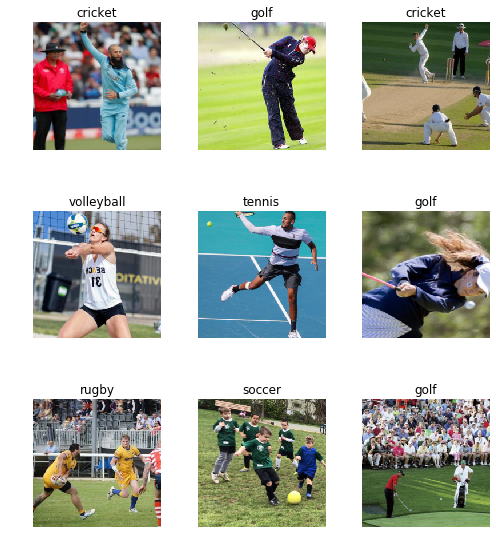

In [0]:
data.show_batch(rows=3, figsize=(7,8))

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['baseball',
  'basketball',
  'cricket',
  'curling',
  'golf',
  'hockey',
  'rugby',
  'soccer',
  'tennis',
  'volleyball'],
 10,
 570,
 142)

## Training The Model

### Resnet34

First, a resnet34 was created and trained on the data for a total of 4 epochs. The end result was a model with an error rate of slightly over 11%. This was already a significant improvement over the initial results from the model trained with unfiltered Google Image search results, and was almost as good as the best model I was able to train with the unfiltered dataset - despite having less than half the amount of data that those models did. 

After training the network for an additional 2 more epochs, the error rate was around 8%, and was clearly superior to any of the models trained on the unfiltered images.

Clearly, improving the dataset made a big difference in improving the accuracy of the network.

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.529877,1.295195,0.345070,00:09
1,1.634820,0.477005,0.147887,00:08
2,1.158493,0.350768,0.091549,00:08
3,0.910895,0.356286,0.112676,00:08


In [0]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.293141,0.309985,0.098592,00:08
1,0.258104,0.297797,0.084507,00:08


In [0]:
learn.save('resnet34-1')

In order to see what images were proving most troublesome for the network, the top losses were plotted, and a confusion matrix was generated. 

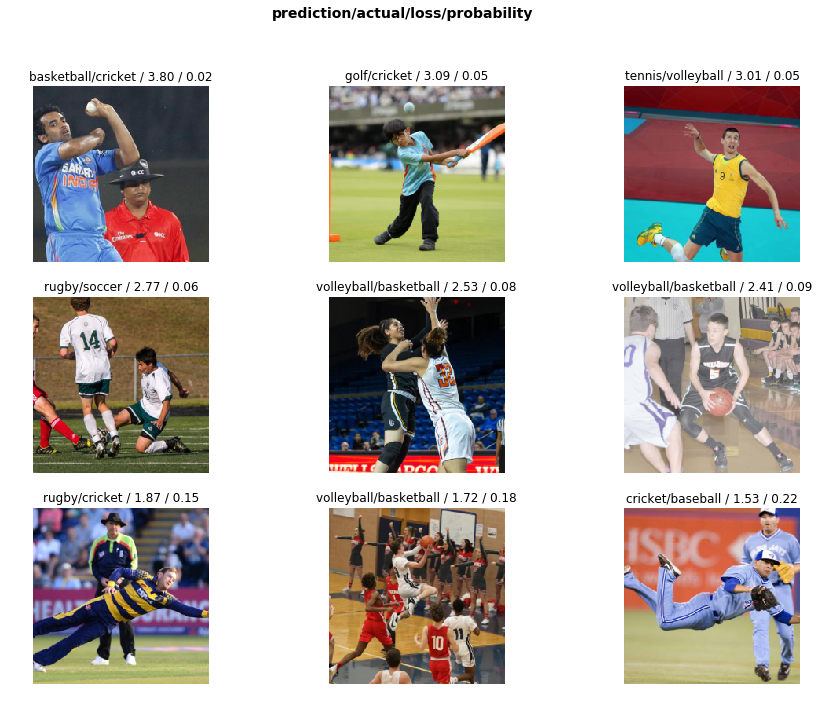

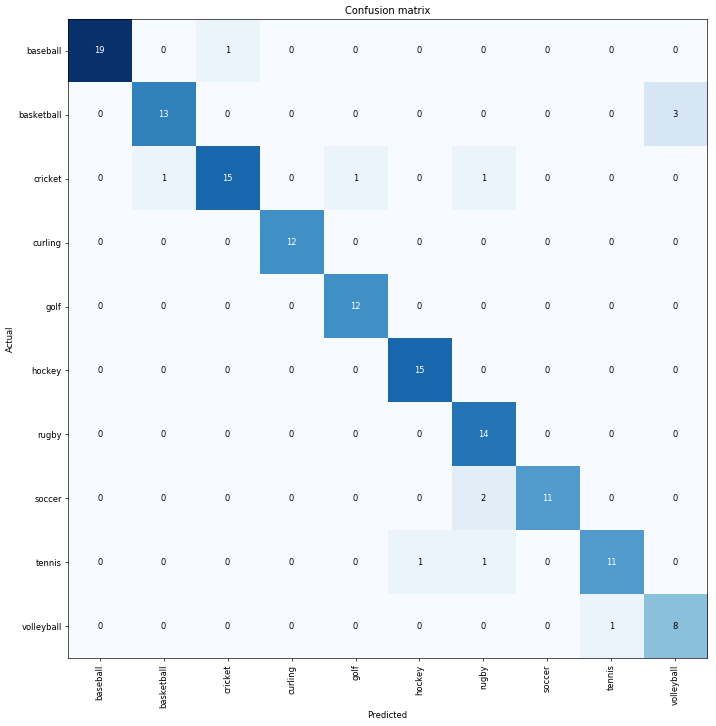

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

interp.plot_top_losses(9, figsize=(15,11))

interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

I also decided to check which sports were being confused most often. (The output is in the format `actual class, predicted class, number of confusions`)

In [0]:
interp.most_confused(min_val=2)

[('basketball', 'volleyball', 3), ('soccer', 'rugby', 2)]

In order to further maximize the performance of the resnet34 network, I unfroze the top layers and began to tweak all the layers at differing speed (ie. different learning rate constants).

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


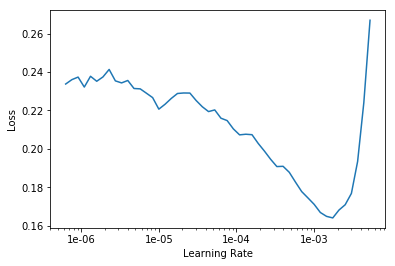

In [0]:
learn.unfreeze()

learn.lr_find()

learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.209732,0.283874,0.077465,00:08
1,0.185333,0.254694,0.098592,00:08
2,0.168455,0.246233,0.091549,00:08


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


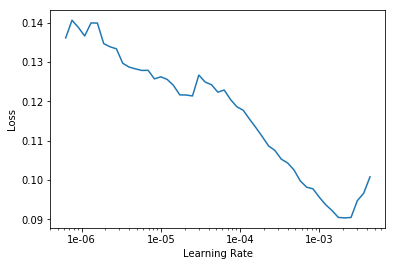

In [0]:
learn.lr_find()

learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, max_lr=slice(1e-6,3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.126250,0.217616,0.091549,00:09
1,0.110550,0.216657,0.091549,00:08
2,0.096942,0.215075,0.077465,00:09


In [0]:
learn.unfreeze()

learn.fit_one_cycle(3, max_lr=slice(1e-6,3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.065208,0.229586,0.084507,00:09
1,0.065035,0.202135,0.070423,00:08
2,0.061536,0.190785,0.063380,00:08


I decided to stop training this model once I got an error rate of under 7%, since it seemed to have trouble going below that. I wasn't sure if further training would increase or decrease the model's error rate, so I decided that was enough.

In [0]:
learn.unfreeze()

learn.fit_one_cycle(1, max_lr=slice(1e-6,3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.068272,0.185972,0.049296,00:09


[('basketball', 'volleyball', 2)]

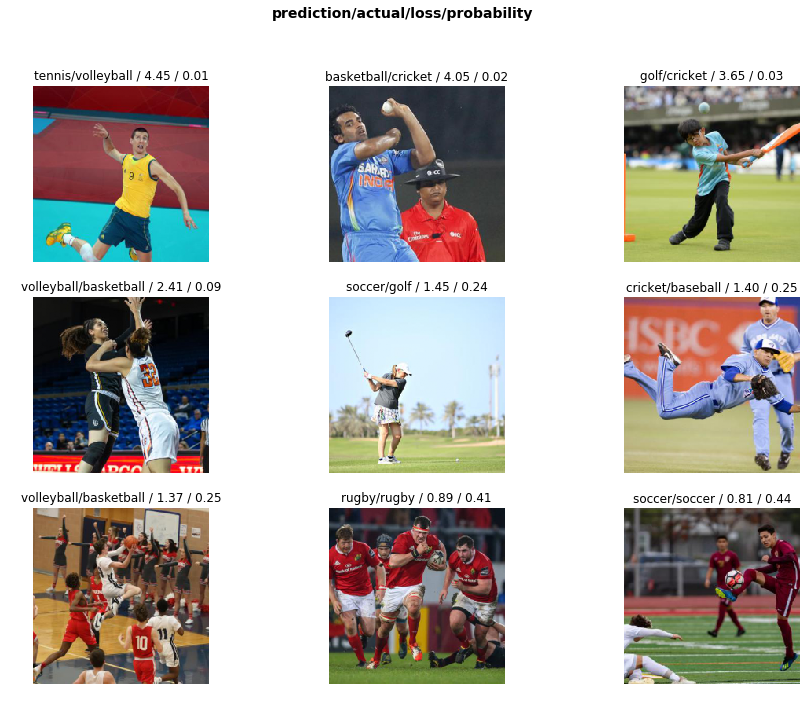

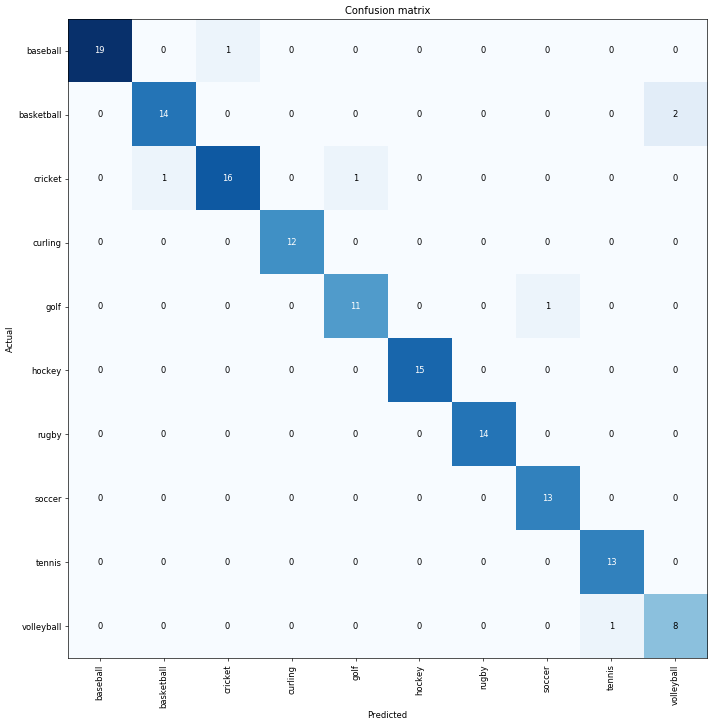

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

interp.plot_top_losses(9, figsize=(15,11))

interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

interp.most_confused(min_val=2)

In [0]:
learn.save('resnet34-2')

### Resnet50

Since the error rate performance of the resnet34 appeared to be stuck in a local minimum, I switched to using a resnet50 model. I initially trained it for 6 epochs, at which point it had equalled the performance of my final resnet34 network.


In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.884874,0.683773,0.232394,00:10
1,1.029500,0.283269,0.105634,00:10
2,0.698399,0.221217,0.077465,00:10
3,0.522466,0.211910,0.084507,00:10


In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.134874,0.172874,0.077465,00:09


In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.130029,0.148403,0.063380,00:10


[('soccer', 'rugby', 3), ('cricket', 'rugby', 2)]

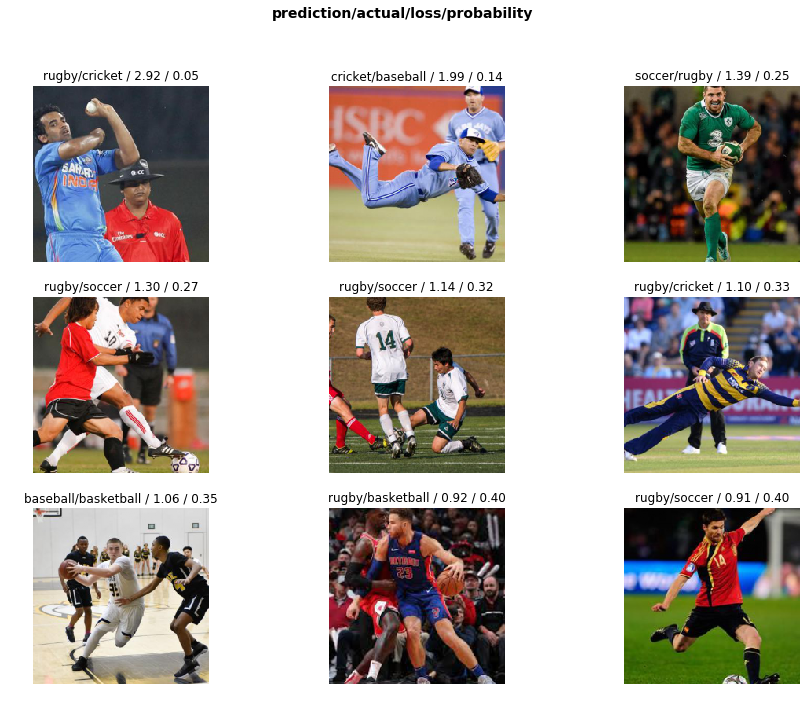

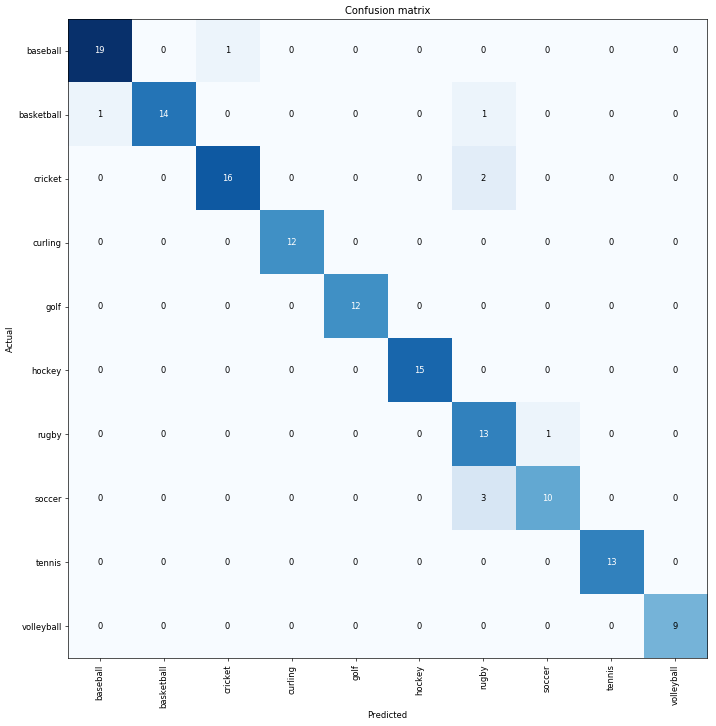

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

interp.plot_top_losses(9, figsize=(15,11))

interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

interp.most_confused(min_val=2)

In [0]:
learn.save('resnet50-1')

After further tweaking, the model's error rate appeared to have reached a local minimum under 5%, at which point I was happy with its performance.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


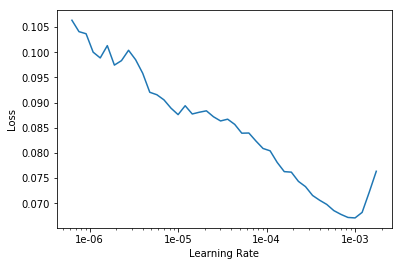

In [0]:
learn.unfreeze()

learn.lr_find()

learn.recorder.plot()

In [0]:
learn.unfreeze()

learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.100448,0.147302,0.056338,00:11
1,0.086233,0.168465,0.084507,00:10
2,0.072689,0.161875,0.084507,00:10
3,0.065281,0.155661,0.063380,00:10


In [0]:
learn.unfreeze()

learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.030931,0.133606,0.049296,00:10
1,0.030895,0.126465,0.049296,00:10
2,0.024603,0.117530,0.049296,00:10
3,0.022739,0.115502,0.049296,00:10


Furthermore, none of the sports were confused for one another more than once. With that done, I decided to export this model since I was happy with its performance.

[]

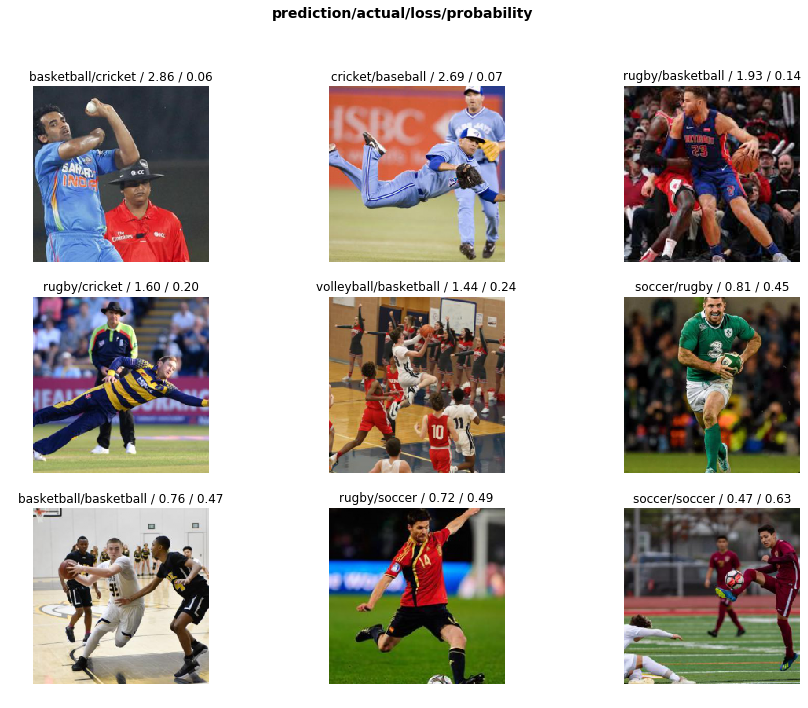

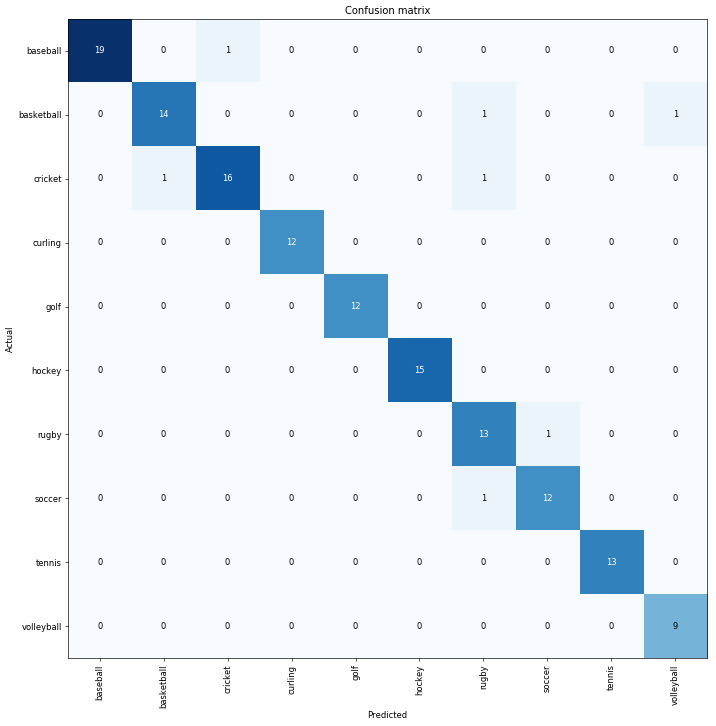

In [0]:
learn.save('resnet50-2')

interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

interp.plot_top_losses(9, figsize=(15,11))

interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

interp.most_confused(min_val=2)

In [0]:
learn.export('resnet50main.pkl')